# 1. Install Dependencies

In [1]:
import tensorflow as tf
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score
from sklearn.metrics import confusion_matrix
import random
import shutil
from sklearn.utils import resample
from tensorflow.keras.models import load_model

# 2. Prepare Dataset

In [71]:
# Source paths
source_dirs = ['test', 'train', 'val']

# Destination paths
dest_dir = '../data'
categories = ['NORMAL', 'PNEUMONIA']

# Create the destination folder and subfolders if they do not exist
for category in categories:
    os.makedirs(os.path.join(dest_dir, category), exist_ok=True)

In [72]:
# Function to move files and delete the source directory
def move_files(source_dir, dest_dir):
    for category in categories:
        source_category_dir = os.path.join(source_dir, category)
        dest_category_dir = os.path.join(dest_dir, category)
        
        if not os.path.exists(source_category_dir):
            print(f"Source directory {source_category_dir} does not exist.")
            continue
        
        for filename in os.listdir(source_category_dir):
            source_file = os.path.join(source_category_dir, filename)
            dest_file = os.path.join(dest_category_dir, filename)
            
            try:
                if os.path.exists(dest_file):
                    print(f"File {dest_file} already exists. Skipping...")
                    continue
                shutil.move(source_file, dest_file)
                print(f"Moved {source_file} to {dest_file}")
            except Exception as e:
                print(f"Error moving {source_file} to {dest_file}: {e}")

        # Try to remove the category directory if it's empty
        try:
            os.rmdir(source_category_dir)
            print(f"Deleted empty directory {source_category_dir}")
        except OSError as e:
            print(f"Directory {source_category_dir} is not empty: {e}")
    
    # Try to remove the main source directory if it's empty
    try:
        os.rmdir(source_dir)
        print(f"Deleted empty directory {source_dir}")
    except OSError as e:
        print(f"Directory {source_dir} is not empty or cannot be removed: {e}")

In [73]:
# Move files from each source directory to the destination directory
for source_dir in source_dirs:
    move_files(source_dir, dest_dir)

Moved test\NORMAL\IM-0001-0001.jpeg to ../data\NORMAL\IM-0001-0001.jpeg
Moved test\NORMAL\IM-0003-0001.jpeg to ../data\NORMAL\IM-0003-0001.jpeg
Moved test\NORMAL\IM-0005-0001.jpeg to ../data\NORMAL\IM-0005-0001.jpeg
Moved test\NORMAL\IM-0006-0001.jpeg to ../data\NORMAL\IM-0006-0001.jpeg
Moved test\NORMAL\IM-0007-0001.jpeg to ../data\NORMAL\IM-0007-0001.jpeg
Moved test\NORMAL\IM-0009-0001.jpeg to ../data\NORMAL\IM-0009-0001.jpeg
Moved test\NORMAL\IM-0010-0001.jpeg to ../data\NORMAL\IM-0010-0001.jpeg
Moved test\NORMAL\IM-0011-0001-0001.jpeg to ../data\NORMAL\IM-0011-0001-0001.jpeg
Moved test\NORMAL\IM-0011-0001-0002.jpeg to ../data\NORMAL\IM-0011-0001-0002.jpeg
Moved test\NORMAL\IM-0011-0001.jpeg to ../data\NORMAL\IM-0011-0001.jpeg
Moved test\NORMAL\IM-0013-0001.jpeg to ../data\NORMAL\IM-0013-0001.jpeg
Moved test\NORMAL\IM-0015-0001.jpeg to ../data\NORMAL\IM-0015-0001.jpeg
Moved test\NORMAL\IM-0016-0001.jpeg to ../data\NORMAL\IM-0016-0001.jpeg
Moved test\NORMAL\IM-0017-0001.jpeg to ../da

In [74]:
# Define the variable to the created directories
data_dir = '../data'
normal_dir = os.path.join(data_dir, 'NORMAL')
pneumonia_dir = os.path.join(data_dir, 'PNEUMONIA')

# Count the number of images in each folder
normal_images = os.listdir(normal_dir)
pneumonia_images = os.listdir(pneumonia_dir)

num_normal = len(normal_images)
num_pneumonia = len(pneumonia_images)
print(f"There are: {num_normal} normal images (label=0) and {num_pneumonia} of pneumonia (label=1).")

There are: 1583 normal images (label=0) and 4273 of pneumonia (label=1).


# 3. Load Data

In [76]:
# Load the data using Keras dataset function
data = tf.keras.utils.image_dataset_from_directory('../data',
    labels='inferred',
    image_size=(128, 128),
    color_mode='rgb',
    shuffle=True,
)

Found 5856 files belonging to 2 classes.


In [40]:
# Pipeline iterator 
data_iterator = data.as_numpy_iterator()

In [41]:
# Get a batch from the pipeline
batch = data_iterator.next()

In [42]:
# Verify the maximum intensity value for the pixels
data.as_numpy_iterator().next()[0].max()

255.0

In [43]:
# Verify the shape of one batch
batch[0].shape

(32, 128, 128, 3)

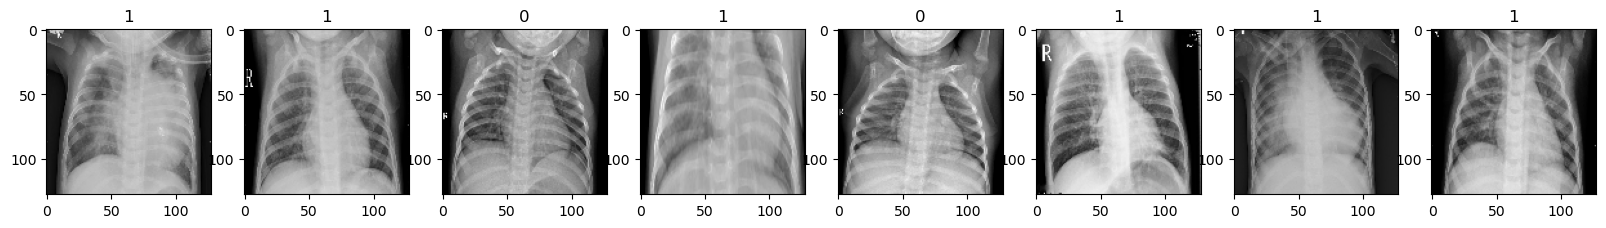

In [44]:
# Plot the images
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int), cmap='gray')
    ax[idx].title.set_text(batch[1][idx])

# 4. Pre-processing Data: Scale Data

In [45]:
# Scale the pixel values to 0-1 using a map which is a pipeline tranformation function
data = data.map(lambda x,y: (x/255, y))

In [46]:
# Verify the maximum intensity value for the pixels after transformation
data.as_numpy_iterator().next()[0].max()

1.0

# 4. Pre-processing Data: Split Data

In [47]:
# Total number of batches
len(data)

183

In [48]:
# Split the data into 80% for training, and 10% for validation and testing
train_size = int(len(data)*.80) +1
val_size = int(len(data)*.10)
test_size = int(len(data)*.10) 

In [49]:
train_size + val_size +  test_size

183

In [50]:
# Use take and skip methods to control the splitted data ingestion
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 5. Build Deep Learning Model

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [52]:
# Use a sequantial model 
model = Sequential()

In [53]:
# Add the first convolutional layer with 16 filters, a 3x3 kernel, stride of 1, and ReLU activation function
# This layer also specifies the input shape of the images: 128x128 pixels with 3 color channels (RGB)
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(128,128,3)))
# Add a max pooling layer to reduce the spatial dimensions (downsampling)
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Flatten the output from the previous layer to convert it into a 1D array
# This step is necessary before feeding the data into the dense (fully connected) layers
model.add(Flatten())

# Add a fully connected layer with 128 neurons and ReLU activation function
model.add(Dense(128, activation='relu'))
# Add the output layer with a single neuron and sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [54]:
# Using Adam optimizer and binary crossentropy loss function for binary classification
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,377 (1.57 MB)

 Trainable params: 411,377 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

# 6. Train Model

In [56]:
# Train the model
# Epochs specify that the training process will iterate over the entire training dataset 8 times.
hist = model.fit(train, epochs=8, validation_data=val)

Epoch 1/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 87s 561ms/step - accuracy: 0.7888 - loss: 0.4682 - val_accuracy: 0.9149 - val_loss: 0.2090
Epoch 2/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 140s 544ms/step - accuracy: 0.9313 - loss: 0.1807 - val_accuracy: 0.9549 - val_loss: 0.1322
Epoch 3/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 79s 527ms/step - accuracy: 0.9443 - loss: 0.1410 - val_accuracy: 0.9115 - val_loss: 0.2155
Epoch 4/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 79s 526ms/step - accuracy: 0.9394 - loss: 0.1526 - val_accuracy: 0.9444 - val_loss: 0.1489
Epoch 5/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 82s 554ms/step - accuracy: 0.9536 - loss: 0.1270 - val_accuracy: 0.9340 - val_loss: 0.1648
Epoch 6/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 87s 580ms/step - accuracy: 0.9547 - loss: 0.1181 - val_accuracy: 0.9462 - val_loss: 0.1281
Epoch 7/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 85s 566ms/step - accuracy: 0.9621 - loss: 0.1130 - val_accuracy: 0.9479 - val_loss: 0.1499
Epoch 8/8
147/147 ━━━━━━━━━━━━━━━━━━━━ 84s 560ms/step - accuracy: 0.9654 - loss: 0.0988 -

# 7. Plot Performance

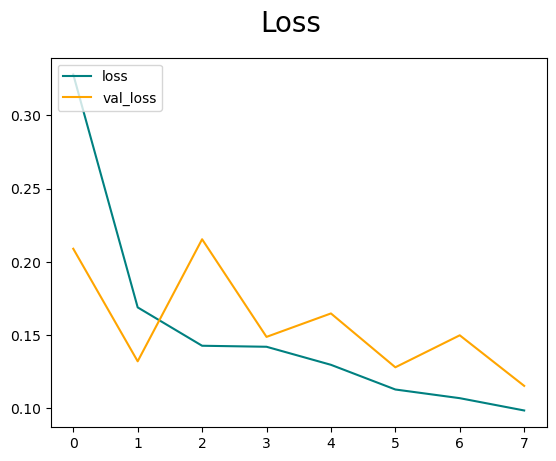

In [57]:
# Plot the loss and validation loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

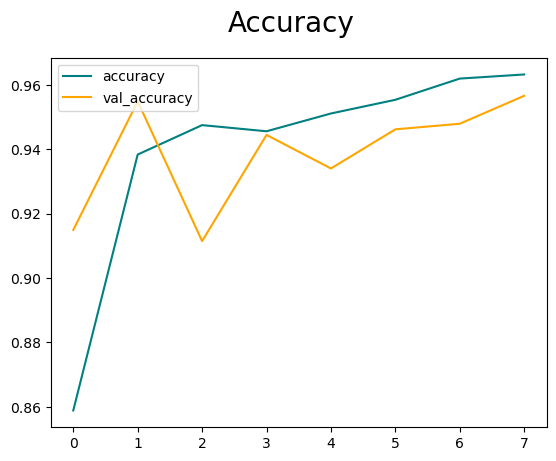

In [58]:
# Plot the accuracy and the validation accuracy 
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Evaluate

In [59]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [60]:
# Iterate over batches in the test dataset.
# Predict using the model, update states for precision, recall, and accuracy metrics.
# Convert predictions to binary using a threshold of 0.5, extend y_pred and y_true lists.
y_true = []
y_pred = []
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    mask = (yhat > 0.5).flatten()
    mask = np.array(mask, dtype=int).tolist()
    y_pred.extend(mask)
    y_true.extend(y.astype(int))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


In [61]:
# Print precision, recall, and accuracy metrics
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.973557710647583, Recall:0.9688995480537415, Accuracy:0.9583333134651184


In [62]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

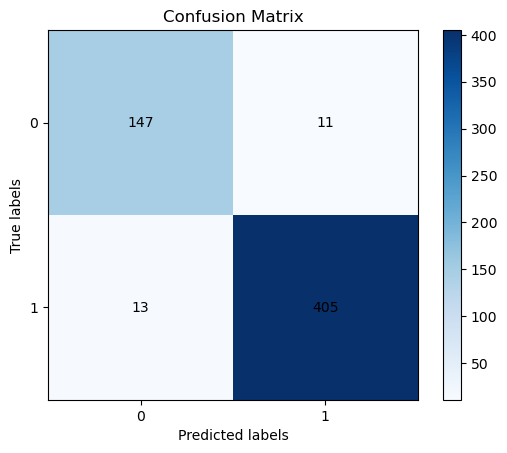

In [63]:
# Plot confusion matrix
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Add annotation
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[0])):
        plt.text(j, i, str(conf_matrix[i][j]), ha='center', va='center', color='black')

plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])
plt.show()

# 9. Save the trained model

In [ ]:
# Save the trained model to disk
#model.save('CNN_model.keras')

In [70]:
# Load the saved model if required
#loaded_model = load_model('CNN_model.keras')